

### Source of Paper YOLO V1 :
https://arxiv.org/pdf/1506.02640.pdf

### Source of Paper YOLO V2 :
https://arxiv.org/pdf/1612.08242.pdf

### Source of Paper YOLO V3 :
https://arxiv.org/pdf/1804.02767.pdf

### Source of Paper YOLO V4 :
https://arxiv.org/pdf/2004.10934.pdf

### Slides for Reference :
https://docs.google.com/presentation/d/1aeRvtKG21KHdD5lg6Hgyhx5rPq_ZOsGjG5rJ1HP7BbA/pub?start=false&loop=false&delayms=3000&slide=id.p



#  YOLO1 Detailed

Unlike the RCNN, YOLO treats object detection as a single regression problem, and generates bounding box coordinates and classification probabilities directly from the image. You only need to detect this image once to predict the objects in the image and get their specific locations. RPN predicts the offset of the prediction box and anchor, while YOLO predicts the relative offset of the center point of the predicted bounding box relative to the upper left corner of the corresponding cell.


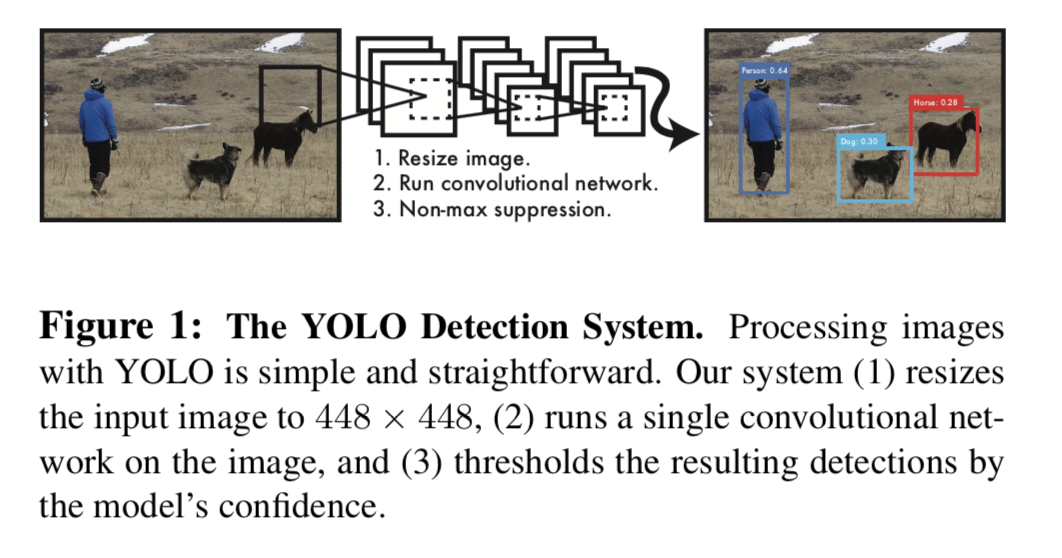

### Model

YOLO regards target detection as a regression problem. It divides the image into S * S grids. If the center of the object falls into a grid, then this grid is responsible for detecting the object and the positions of these bounding boxes, Confidence, category probability . Confidence reflects how confident the model is about the presence of objects in the boxes and the accuracy of the predictions. Confidence level is defined as: 


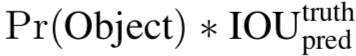


if the object does not mesh, the confidence is defined as 0, otherwise the confidence is equal to the predicted block and the real deposit and the ratio of the frame. Each bounding box contains 5 prediction values: x, y, w, h, and confidence, where x and y represent the center of the prediction box relative to the grid boundary, w and h are the width and height of the box, and confidence represents the prediction. The intersection of box and real box is better than IoU. The prediction result can be expressed by SxSx (B * 5 + C) parameters. Running YOLO on PASCAL VOC, S = 7, each grid predicts B = 2 objects, PASCAL VOC has 20 categories, so the number of categories is C = 20, and our prediction result is a 7x7x30 tensor.


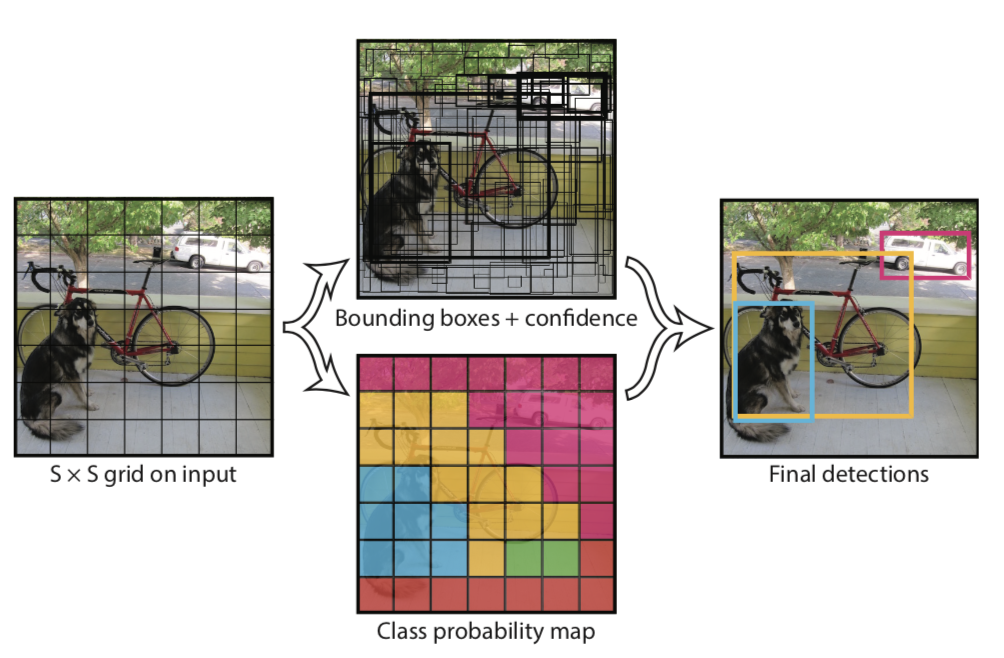

Each grid also detects conditional category probabilities as: 

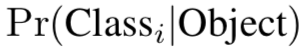
This is the probability that a certain category of objects is contained in a grid. No matter how many boxes are contained in the grid, we only predict a set of class probabilities for each grid. When testing, we multiply the conditional class probability and the confidence of the prediction box to indicate that each box contains the confidence of a certain type of object. This score can represent the category probability and prediction accuracy of the box at the same time.


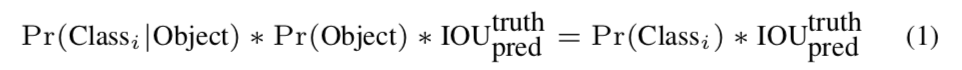

### 2. Network Structure Design-GoogLe Net

The convolutional layer of the network is used to extract image features, while the fully connected layer predicts class possibilities and target locations.

The network uses GoogLe Net for image classification. There are 24 convolutional layers + 2 fully connected layers. However, instead of using GoogLe Net's inception module, 1 * 1 filters are used instead (reducing the number of parameters in the previous layer). ) + 3 * 3 convolution layer. The classification network is pre-trained on ImageNet with 224 * 224, and the target detection input image is twice the size of the classification network (448 * 448). The network structure is shown in the figure:

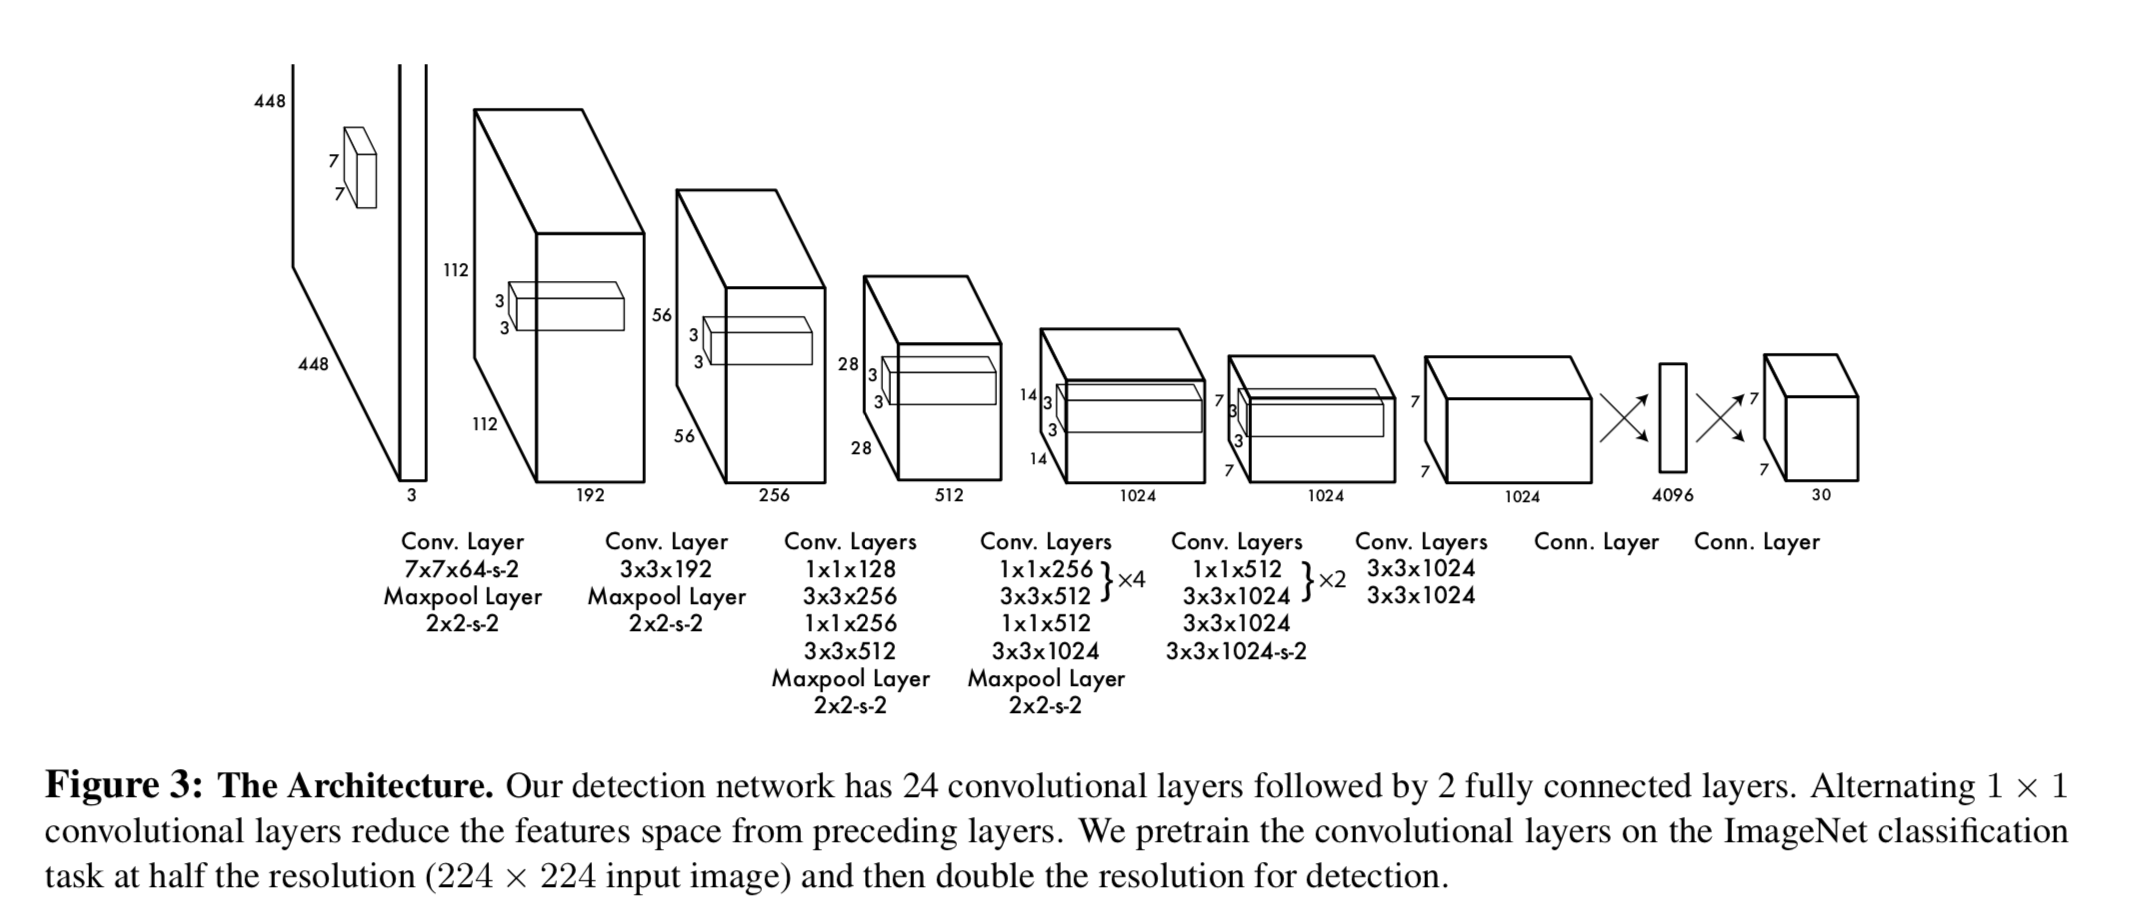

We also trained a Fast YOLO to accelerate the prediction of target detection boundaries. It uses a neural network with only a few convolutional layers and a few filters. Other parameters are consistent with YOLO.

### 3. Training

First, the classification network is pre-trained on ImageNet containing 1000 classes. For pre-training, the first 20 convolutional layers are followed by an average pooling layer and a fully connected layer. This model is then applied to the target detection network. Four new convolutional layers and two fully connected layers are added, and the weights are randomly initialized. Object detection usually requires finer-grained visualization information, so the resolution of the input image is increased from 224 * 224 to 448 * 448. The last layer predicts both the class likelihood and the position of the bounding box. Normalize the width and height of the bounding box so that they are distributed in the 0-1 interval. The x and y parameters are the offsets of the prediction box from the grid position and are also limited to 0-1. The last layer uses a linear activation function, while all other layers use Leaky ReLU activation functions, as follows:


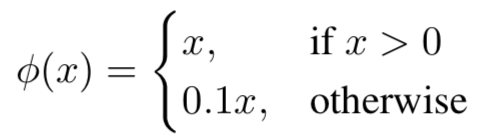


### 4. Loss function

Optimize the output using square sum loss because it is easier to manipulate, but:

(1) It considers that the positioning error and the classification error have the same weight, and in each image, many grids do not contain any objects, which will make these grids have a confidence of 0, overriding the gradient of those grids that contain objects Causes model instability. To solve this problem, we increase the loss of box regression prediction, reduce the loss of those boxes without objects , use 2 parameters 

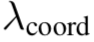




and 

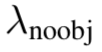


adjust it, where 

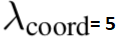

and 
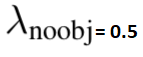

(2) It thinks that the losses of large boxes and small boxes have the same weight. In our grid design, it is obvious that the losses of large boxes are more important than the losses of small boxes . To solve this problem, when predicting the bounding box, instead of directly using width / height, use the square root of width / height .

Each grid can predict multiple bounding boxes. During training, a predictor with the highest IoU and true value is designated to predict this goal . This will make each predictor predict a specific size, aspect ratio, and object category. Do better.

The loss function is defined as ( x, y loss at the center of the prediction box + loss w, h of the prediction box width and loss + confidence loss + classification loss ):

Not all outputs of the network need to be calculated for loss:

* There is a cell falling into the center of the object, and the classification loss needs to be calculated.
* Both predictors have to calculate the confidence loss,
* The predictor with the larger bounding box and greater truth IOU needs to calculate the xywh loss.
* The most critical part is that there is no cell falling into the center of the object, and only the loss of confidence needs to be calculated.



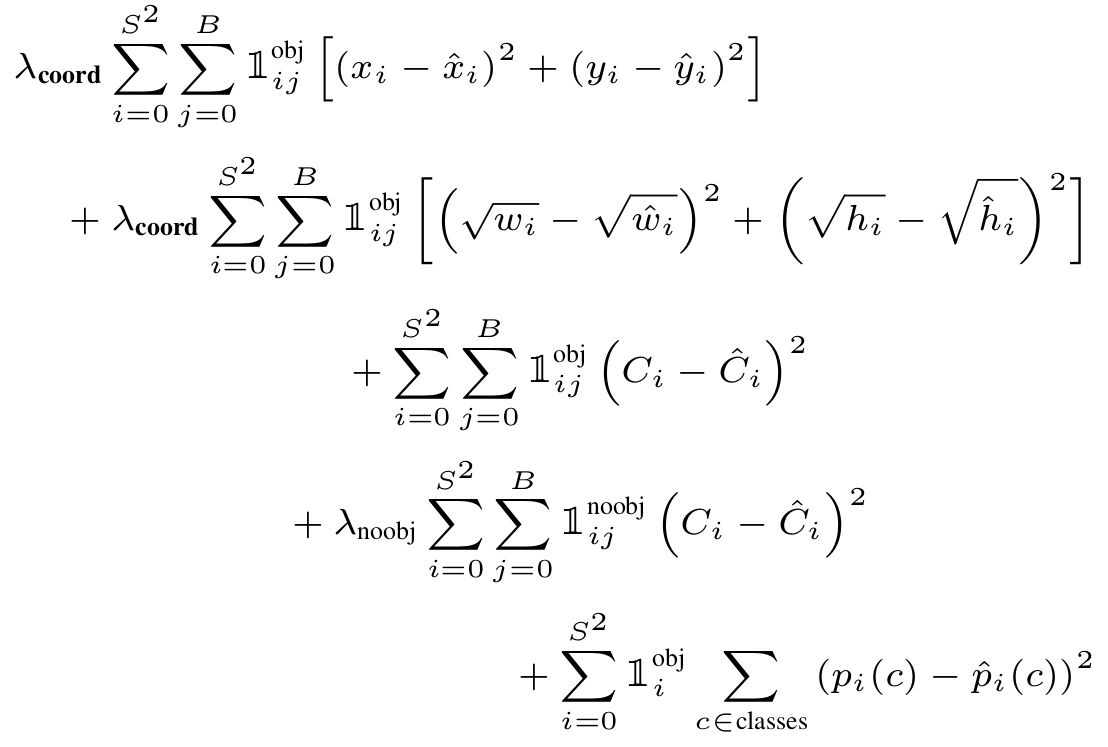

* $S^2$ represents the number of grids, which is 7x7 in the text. B represents the number of prediction frames for each grid, which is 2 in the text.

* 
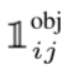 Values are 0 and 1, indicating whether there are targets in the cell.

* λcoord = 5, λnoobj = 0.5. It is a balance factor that balances the box coordinate loss and the box loss without objects.

* The first line uses the sum of squares error as the loss function for the center position prediction.

* The second line uses the square root sum error as a loss function for width and height.

* The third and fourth lines use the sum of squares error as a loss function for confidence.

* The fifth line uses the sum of squares error as a loss function for the category probability.

* Finally, several loss functions are added together as the loss function of yolo v1.

### 5. Hyperparameter setting

batch_size = 64, momentum = 0.9, weight decay = 0.0005

The first epochs and learning rate slowly increase from 0.001 to 0.01. If starting from a high learning rate, the gradient may be unstable, which may cause model divisions. Then train 75 iterations with a learning rate of 0.01, 30 iterations with 0.001, and 30 iterations with 0.0001.

In order to prevent overfitting, dropout and data enhancement are used, and the dropout ratio is 0.5

### 6.NMS

Some large targets may be located by multiple grids at the same time. NMS can solve this multiple prediction problem.

### 7. YOLO advantages

(1) Fast. Because we regard it as a regression problem, without the need for complex pipelines , when testing, we only need to put the new image into the neural network and run it. It can achieve real-time effects, and mAP is higher.

(2) Have a global understanding of the image. Unlike the technology based on sliding window and region proposal, YOLO implicitly encodes the context information of the target's category and its appearance, while Fast RCNN cannot see the larger context information. YOLO uses the characteristics of the entire image to predict each bounding box , and simultaneously predicts all categories of bounding boxes in the image, that is, it has a global understanding of the image.

(3) The learning of goals is more general.

(4) High accuracy and can quickly locate the target and position in the image, even small targets.

(5) The design of the grid unit can alleviate the problem of detecting the same object multiple times.

(6) Provides fewer bounding boxes, only 98 images per image , and about 2000 selective search.

(7) Combine these separate components into a single joint optimization model.

(8) YOLO is a more versatile detector that can detect multiple objects simultaneously

### 8.Flaws of YOLO

(1) Since each grid only predicts 2 bounding boxes, this limits the number of objects that the model can predict

(2) Downsampling is used many times, so the bounding box of the prediction model uses relatively rough features.